In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

In [2]:
def generate_correlated_lognormal_field(
    key,
    shape=(100, 100),
    mean=1.0,
    length_scale=0.1,
    sigma_g=1.0,
    percentile=99
):
    """
    Generate a 2D log-normal random field with spatial correlations.

    Args:
        key: JAX PRNG key.
        shape: tuple (Nx, Ny) of field dimensions.
        mean: desired mean of the real-space log-normal field.
        length_scale: controls correlation (smaller = more small-scale structure).
        sigma_g: std dev of the Gaussian log field (controls contrast).
        percentile: used to return a mask of "top X%" regions.

    Returns:
        field: 2D log-normal field with spatial correlation and given mean.
        top_mask: binary mask of top percentile pixels (e.g., top 1%)
    """
    Nx, Ny = shape
    key, subkey = random.split(key)

    # --- Step 1: define k-space grid
    kx = jnp.fft.fftfreq(Nx) / length_scale
    ky = jnp.fft.fftfreq(Ny) / length_scale
    kx_grid, ky_grid = jnp.meshgrid(kx, ky, indexing='ij')
    k = jnp.sqrt(kx_grid**2 + ky_grid**2)

    # --- Step 2: Power spectrum (Gaussian in log-k)
    k0 = 1.0
    log_k = jnp.log(jnp.clip(k, a_min=1e-6))  # avoid log(0)
    log_k0 = jnp.log(k0)
    sigma_k = 0.5
    P_k = jnp.exp(-0.5 * ((log_k - log_k0) / sigma_k)**2)
    P_k = P_k.at[0, 0].set(0.0)  # zero DC

    # --- Step 3: Generate Gaussian field in Fourier space
    phases = jnp.exp(2j * jnp.pi * random.uniform(subkey, (Nx, Ny)))
    amplitude = jnp.sqrt(P_k)
    fft_field = amplitude * phases

    # Hermitian symmetry for real field
    if Nx % 2 == 0:
        fft_field = fft_field.at[Nx // 2, :].set(fft_field[Nx // 2, :].real)
    if Ny % 2 == 0:
        fft_field = fft_field.at[:, Ny // 2].set(fft_field[:, Ny // 2].real)
    ix = jnp.arange(0, Nx // 2)
    iy = jnp.arange(0, Ny // 2)
    fft_field = fft_field.at[-ix[:, None], -iy[None, :]].set(jnp.conj(fft_field[ix[:, None], iy[None, :]]))

    # --- Step 4: Inverse FFT → correlated Gaussian field
    g = jnp.fft.ifft2(fft_field).real
    g = (g - jnp.mean(g)) / jnp.std(g)  # normalize to mean=0, std=1
    g = sigma_g * g

    # --- Step 5: Exponentiate to log-normal
    lognormal_field = jnp.exp(g)

    # --- Step 6: Rescale to desired mean
    current_mean = jnp.mean(lognormal_field)
    field = lognormal_field * (mean / current_mean)

    # --- Step 7: Create top-X% mask
    threshold = jnp.percentile(field, percentile)
    top_mask = field >= threshold

    return field, top_mask



In [3]:
def compute_intensity(
        shape=(100, 100),
        field=1,
        sigma_value = 0.05
        
):
    # Grid and parameters
    #Nx, Ny = 100, 100
    Nx, Ny = shape
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx / Nx, Ly / Ny
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Opacity and emissivity
    kappa = field # 1.0 ## here your density field
    j0 = 10.0
    xc, yc = Lx / 2, Ly / 2
    sigma = sigma_value # 0.05
    j_emissivity = j0 * np.exp(-((X - xc)**2 + (Y - yc)**2) / (2 * sigma**2))

    # Angular discretization
    N_theta = 16
    theta_list = np.linspace(0, 2 * np.pi, N_theta, endpoint=False)

    # Storage for total intensity
    J = np.zeros((Nx, Ny))


    # Solve RTE for each angle
    for theta in theta_list:
        mu_x = np.cos(theta)
        mu_y = np.sin(theta)
        I = np.zeros((Nx, Ny))
        
        # Determine sweep order based on angle
        i_range = range(Nx) if mu_x >= 0 else range(Nx - 1, -1, -1)
        j_range = range(Ny) if mu_y >= 0 else range(Ny - 1, -1, -1)
        
        for i in i_range:
            for j in j_range:
                if (i - np.sign(mu_x) < 0 or i - np.sign(mu_x) >= Nx or
                    j - np.sign(mu_y) < 0 or j - np.sign(mu_y) >= Ny):
                    I_up_x = 0.0
                    I_up_y = 0.0
                else:
                    I_up_x = I[int(i - np.sign(mu_x)), j]
                    I_up_y = I[i, int(j - np.sign(mu_y))]
                denom = abs(mu_x) / dx + abs(mu_y) / dy + kappa[i, j]
                I_avg = (abs(mu_x) * I_up_x / dx + abs(mu_y) * I_up_y / dy) / denom
                source = j_emissivity[i, j] / denom
                I[i, j] = I_avg + source
                #I = I.at[i,j].set(I_avg + source) -> use when using jnp instead of np
        
        J += I  # Accumulate for mean intensity

    # Compute mean intensity
    J /= N_theta
    return J.T 

# I can make this more efficient by vmapping of theta in theta list and by using fori_loop instead of normal loops 
# with this I can than also vmap the whole function (jit too)

In [4]:
# create training data:

def create_data(
        key,
        shape=(100, 100),
        mean=1.0,
        length_scale=0.1,
        sigma_g=1.0,
        percentile=99,
        sigma=0.05
):
    
    field, mask = generate_correlated_lognormal_field(key, shape, mean, length_scale, sigma_g, percentile)  # maybe don't use as parameters but instead initialize specific parameters in function randomly 
    intensity = compute_intensity(shape, field, sigma)

    return field, mask, intensity
    
# check, if it is necessary to speed up the RTE (and than vmap also create_data) - if so there are some comments above how to speed it up
#create_data_mapped = jax.vmap(create_data, in_axes=(0, None, None, 0, 0, None, 0))
#results = create_data_mapped(keys, (100,100), 1.0, length_scales, sigma_gs, 99, sigmas)

In [5]:
key = random.PRNGKey(0)
result = create_data(key)

In [8]:
# testing 

In [19]:
key = random.PRNGKey(0)
keys = random.split(key, 3)
key2 = random.PRNGKey(1) 
keys2 = random.split(key2, 3)

length_scales = jnp.ones(shape=(3,)) * 0.1
sigma_gs = jnp.ones(shape=(3,)) * 1.5
sigmas = jnp.ones(shape=(3,)) * 0.05

#length_scales = random.uniform(keys2[0], shape=(3,), minval=0.1, maxval=10.0)
#sigma_gs = random.uniform(keys2[1], shape=(3,), minval=0.1, maxval=2.0)
#sigmas = random.uniform(keys2[2], shape=(3,), minval=0.03, maxval=0.07)


In [24]:
results = []
for k, l, sg, s in zip(keys, length_scales, sigma_gs, sigmas):
    result = create_data(k, (100,100), 1.0, l, sg, 99, s)
    #result = create_data(key, (100,100), 1.0, 0.1, 1.5, 99, 0.05) # testing
    results.append(result)



In [25]:
#plt.imshow(results[0][2], origin='lower', extent=[0, 1, 0, 1,], aspect='auto', cmap='inferno')

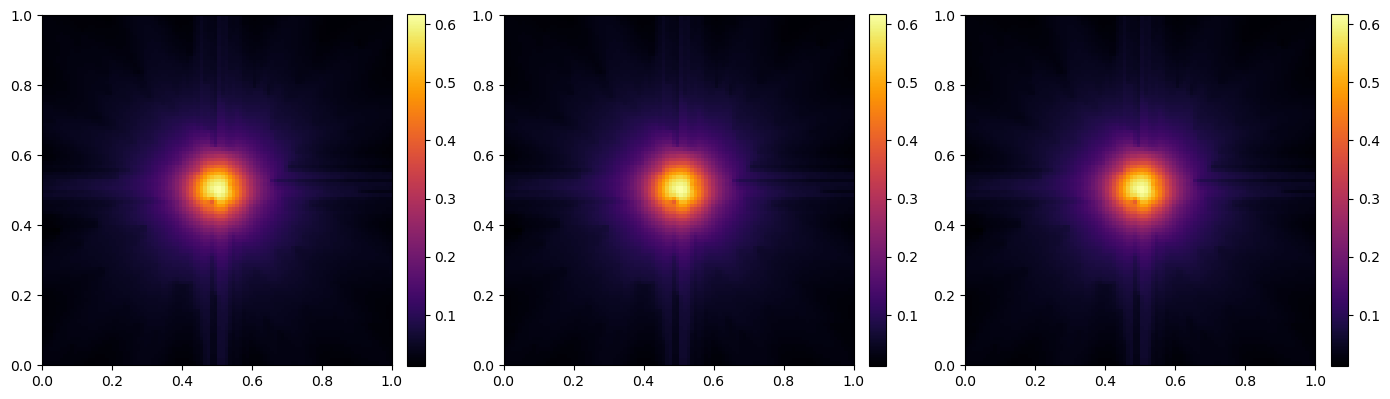

In [26]:
# Define subplot grid
num_rows = 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Flatten the axes array to easily iterate
axes = axes.ravel()

for i, ax in enumerate(axes):
    im = ax.imshow(results[i][2], origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar to each subplot

plt.tight_layout()  # Adjust layout
plt.show()

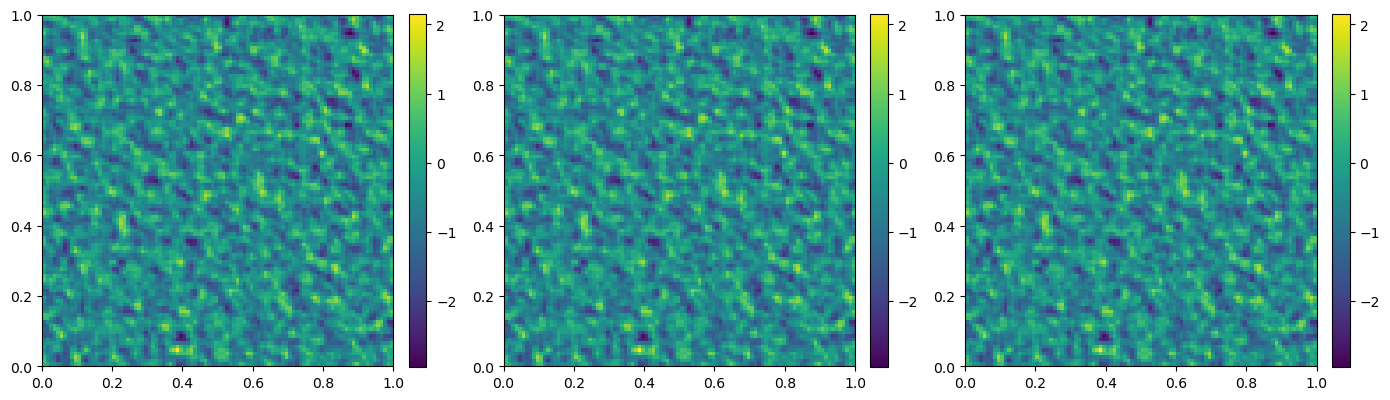

In [28]:
# Define subplot grid
num_rows = 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Flatten the axes array to easily iterate
axes = axes.ravel()

for i, ax in enumerate(axes):
    im = ax.imshow(jnp.log10(results[i][0]), origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='viridis')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()